L'objectif est de proposer une baseline à partir d'un CNN : le modèle choisi est LeNet.

Dans un premier temps, les images sont groupées en 11 classes :

- **BA :** BAsophiles
- **BNE :** NEutrophiles de Bande
- **EO :** EOsinophiles
- **ERB :** ERythroBlastes
- **LY :** LYmphocytes
- **MMY :** MétaMYélocytes
- **MO :** MOnocytes
- **MY :** MYélocytes
- **PLT :** PLaqueTtes
- **PMY :** Promyélocytes
- **SNE :** NEutrophiles Segmentés

Ceci constitue **un autre run du notebook lenet_FINAL.ipynb**

# Modules, connexion au Drive, vérification du GPU

In [ ]:
## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

import sys, os
from pathlib import Path
import glob
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Fri Oct  1 10:48:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |    345MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

# Import des données

Les données de Barcelone ont été placées au préalable dans trois répertoires : training_set, testing_set et validation_set. Cela permet de s'assurer que nous utilisons les mêmes jeux avec tous nos modèles. 

Les données sont stockées sur GoogleDrive, il faut d'abord les importer sur la machine virtuelle de GoogleColab avant de faire quoi que ce soit.

In [ ]:
## Need to copy all the files on the local computer
!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

# Preprocessing des données

On élimine le label "BL" du dataset : trop peu d'images, trop différentes du reste de Barcelone.

On définit une fonction permettant de travailler à 11 ou 8 classes, ce qui sera utile plus loin.


In [ ]:
def choose_classes(df_train, df_test, df_valid, n_classes = 11):

  """ Pour travailler avec 11 ou 8 classes. Les BL (blastes) sont une classe de cellules minoritaires provenant d'un dataset différent de celui fournissant les
  images des N-1 autres classes. En raison d'un biais évident, nous ne travaillons pas avec ces images.
  """

  # Option à 11 classes, sans les BL
  if n_classes == 11:
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

  # Option à 8 classes (IG, SNE et BNE dans la même classe "NEU"), sans les BL :
  if n_classes == 8:

    # Elimine les BL :
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

    # Renomme SNE/BNE en NEU :
    df_train["label_3"] = df_train["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])
    df_valid["label_3"] = df_valid["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])
    df_test["label_3"] = df_test["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])

    # Sélectionne les label_3 comme labels :
    df_train["label"] = df_train["label_3"]
    df_test["label"] = df_test["label_3"]
    df_valid["label"] = df_valid["label_3"]

  return n_classes, df_train, df_test, df_valid

In [ ]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 11)
classes = list(df_train["label"].sort_values().unique())

On découpe les données en une série de batchs de 32 images. Les images sont redimensionnées (256 * 256 pixels). Pour l'instant, on travaille sans augmentation de données.

In [ ]:
########################################################################### Génération d'images ###########################################################################

batch_size = 32
img_height  = 256
img_width = 256

train_generator = ImageDataGenerator()
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()


# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


# Modèle

In [ ]:
model = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, 
                                                 input_shape = (img_height, img_width, 3)),
     layers.Conv2D(filters = 30,
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
     layers.Dense(units = n_classes, activation  = 'softmax')
     ])

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
# Structure du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 252, 252, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

# Modèle à 11 classes

## Entraînement

On adapte le learning-rate au fur et à mesure de l'entraînement grâce à ReduceLROnPlateau. L'entraînement cesse lorsque la valeur de la fonction de coût calculée pour le jeu de validation ne diminue plus.

In [ ]:
## Training

TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set)

Epoch 1/30
397/397 [==============================] - 58s 104ms/step - loss: 1.4313 - accuracy: 0.5137 - val_loss: 0.9325 - val_accuracy: 0.6723
Epoch 2/30
397/397 [==============================] - 41s 104ms/step - loss: 0.9028 - accuracy: 0.6684 - val_loss: 0.8372 - val_accuracy: 0.6711
Epoch 3/30
397/397 [==============================] - 41s 103ms/step - loss: 0.7408 - accuracy: 0.7219 - val_loss: 0.7581 - val_accuracy: 0.7335
Epoch 4/30
397/397 [==============================] - 41s 104ms/step - loss: 0.5919 - accuracy: 0.7790 - val_loss: 0.8588 - val_accuracy: 0.6740
Epoch 5/30
397/397 [==============================] - 41s 104ms/step - loss: 0.4454 - accuracy: 0.8336 - val_loss: 0.6066 - val_accuracy: 0.7803
Epoch 6/30
397/397 [==============================] - 41s 104ms/step - loss: 0.3625 - accuracy: 0.8654 - val_loss: 0.6305 - val_accuracy: 0.7717
Epoch 7/30
397/397 [==============================] - 41s 104ms/step - loss: 0.3325 - accuracy: 0.8752 - val_loss: 0.5836 - val_ac

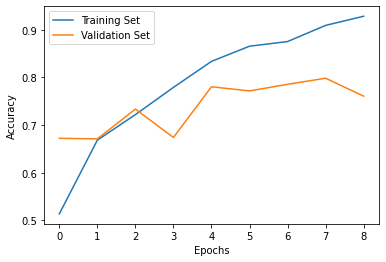

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Évaluation

### Fonctions

In [ ]:
def print_classification_report(testing_set, labels, title):
  """
  Rapport de classification + Matrice de confusion
  """
  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion - "+title)
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report - "+title)
  return y_pred, display(df_report)

In [ ]:
def full_prediction(model, img_path, label, size = (img_height, img_width)):

  ## Preprocessing de l'image
  img = get_img_array(img_path, size = size)

  ## Prediction
  probas = model.predict(img)[0]
  sorted_indexes = np.flip(np.argsort(probas))
  sorted_classes = [classes[i] for i in sorted_indexes]
  sorted_probas = [probas[i] for i in sorted_indexes]
  
  ## Plot (3 classes les plus probables)
  fig = plt.figure(figsize = (7,7))

  ax1 = fig.add_subplot(1,1,1)
  ax1.imshow(plt.imread(img_path))
  ax1.text(x = 10, y = 25, s = 'P(%s) = %0.3f'%(sorted_classes[0], sorted_probas[0]), fontsize = 'xx-large')
  ax1.text(x = 10, y = 55, s = 'P(%s) = %0.3f'%(sorted_classes[1], sorted_probas[1]), fontsize = 'xx-large')
  ax1.text(x = 10, y = 85, s = 'P(%s) = %0.3f'%(sorted_classes[2], sorted_probas[2]), fontsize = 'xx-large')
  ax1.set_title('True label : '+label+'\nPath : '+img_path)
  plt.grid(None)
  plt.axis('off')

  return probas, sorted_probas, sorted_classes

In [ ]:
def get_img_array(img_path, size = (img_height, img_width)):
  """
  Importe une image et applique le preprocessing nécessaire à l'utilisation de Xception : batch + preprocess_input
  """
  img_array = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  img_array = tf.keras.preprocessing.image.img_to_array(img_array)
  img_array = np.expand_dims(img_array, axis = 0)

  return img_array


def make_heatmap(img_array, model, last_conv_layer, class_index):
  """
  Calcule la CAM (Class Activation Map) correspondant au label d'indice "class_index" pour l'image "img_array"
  model : un modèle déjà entraîné, dont on désactive la fonction d'activation en sortie (fait dans grandcam())
  last_conv_layer : dernière couche de convolution du modèle. Trouvée automatiquement par la fonction gradcam()
  class_index : renseigné dans l'appel de gradcam() ou trouvé automatiquement par gradcam()
  """
  grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  # Multiplie chaque carte d'activation par le gradient, puis moyenne
  for i in range(last_conv_layer_output.shape[3]):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)

  return heatmap


def gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.5, plot = True):

  # Désactive softmax sur la dernière couche :
  model.layers[-1].activation = None

  # Détecte la dernière couche de convolution du modèle :
  for layer in reversed(model.layers):
    if 'conv' in layer.name:
      last_conv_layer = model.get_layer(layer.name)
      break

  # Chargement + preprocessing de l'image (conversion, batch, vgg19 special preprocessing):
  img_array = get_img_array(img_path, size = (img_height, img_width))

  # Choix de la classe à représenter (si class_index non renseigné) :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    #model.layers[-1].activation = None                        # Modif
    # Trouve la classe la plus probable :
    predict = model.predict(img_array)
    class_index = np.argmax(predict[0])

  # Calcul de la CAM : resize pour superposition avec l'image finale
  heatmap = make_heatmap(img_array, model, last_conv_layer, class_index)
  big_heatmap = heatmap

  # Réactive softmax :
  model.layers[-1].activation = tf.keras.activations.softmax

  ## Traitement de la Heatmap
  # Applique ReLu (élimine les valeurs négatives de la heatmap)
  big_heatmap = np.maximum(0, big_heatmap)
  # Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()

  ## Superposition de l'image et de la heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)
  # 3/ Jet colormap
  jet = cm.get_cmap("jet")
  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))

  return big_heatmap, superimposed_img

### Performances - métriques :

Évaluons le modèle sur le **jeu de test** :

In [ ]:
model.evaluate(testing_set)

80/80 [==============================] - 7s 89ms/step - loss: 0.5841 - accuracy: 0.7983


[0.5840810537338257, 0.7983490824699402]

Calculons la **matrice de confusion** et le **rapport de classification** pour avoir le détail classe par classe :

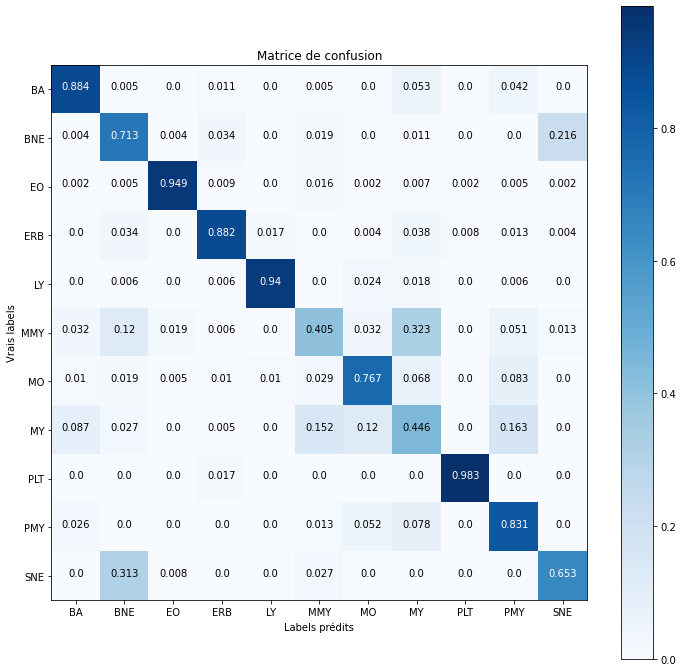

Classification Report 


,precision,recall,f1-score,support
BA,0.860825,0.883598,0.872063,189
BNE,0.610224,0.712687,0.657487,268
EO,0.983213,0.949074,0.965842,432
ERB,0.889362,0.881857,0.885593,237
LY,0.963415,0.940476,0.951807,168
MMY,0.537815,0.405063,0.462094,158
MO,0.810256,0.76699,0.78803,206
MY,0.453039,0.445652,0.449315,184
PLT,0.991667,0.983471,0.987552,363
PMY,0.481203,0.831169,0.609524,77


In [ ]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

### Prédiction pour une image en particulier :

[ 6  9  7  5  0  4  3  2  1  8 10]


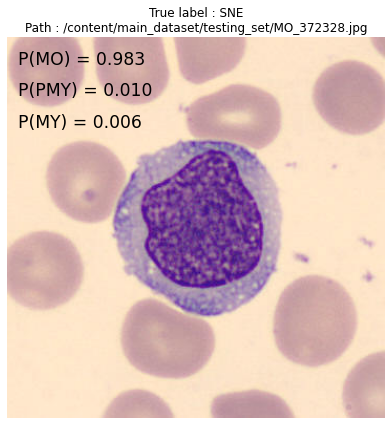

In [ ]:
probas, sorted_probas, sorted_classes = full_prediction(model, 
                                                        "/content/main_dataset/testing_set/MO_372328.jpg", 
                                                        label = 'SNE', 
                                                        size = (img_height, img_width))

(array([[ 54,  33,  43, ..., 115,  93,  71],
        [ 44,  39,  48, ..., 125, 122,  93],
        [ 42,  41,  50, ..., 123, 134, 116],
        ...,
        [103, 102, 101, ...,  79,  80,  78],
        [102, 101, 100, ...,  73,  74,  74],
        [102, 101, 101, ...,  66,  68,  69]], dtype=uint8),
 <PIL.Image.Image image mode=RGB size=360x363 at 0x7F5B7B2E7410>)

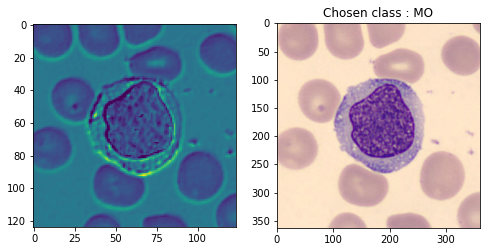

In [ ]:
gradcam(model, "/content/main_dataset/testing_set/MO_372328.jpg", img_height, img_width, class_index = None, alpha = 0, plot = True)

# Modèle à 8 classes 

Ici, on teste une **autre distribution des données**. La répartition des images est faite en **8 classes** :
- **PMY, MY, MMY** sont groupés dans la classe "IG" : immature granulocytes
- **BNE, SNE** sont groupés dans la classe "NEU" : neutrophiles

Techniquement, cela aurait du sens de groupe les BNE dans la catégorie IG, dans la mesure où les BNE sont des neutrophiles immatures. **Nous avons cependant opté pour la répartition proposée dans l'article** "Recognition of peripheral blood cell images using convolutional neural networks" (Acevedo et al., 2019).

In [ ]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 8)
classes = list(df_train["label"].sort_values().unique())

Les images utilisées sont les mêmes que pour 11 classes.

In [ ]:
batch_size = 32
img_height  = 256
img_width = 256

train_generator = ImageDataGenerator()
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()


# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

## Modèle et entraînement

On utilise toujours la même structure pour le modèle (attention, la couche de sortie n'a plus que 8 neurones) :

In [ ]:
model = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, 
                                                 input_shape = (img_height, img_width, 3)),
     layers.Conv2D(filters = 30,
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
     layers.Dense(units = n_classes, activation  = 'softmax')
     ])

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
## Training

TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set)

Epoch 1/30
397/397 [==============================] - 42s 104ms/step - loss: 1.1512 - accuracy: 0.6225 - val_loss: 0.5044 - val_accuracy: 0.8503
Epoch 2/30
397/397 [==============================] - 41s 104ms/step - loss: 0.4741 - accuracy: 0.8366 - val_loss: 0.4123 - val_accuracy: 0.8607
Epoch 3/30
397/397 [==============================] - 41s 103ms/step - loss: 0.3296 - accuracy: 0.8863 - val_loss: 0.3291 - val_accuracy: 0.8942
Epoch 4/30
397/397 [==============================] - 41s 104ms/step - loss: 0.2604 - accuracy: 0.9071 - val_loss: 0.3518 - val_accuracy: 0.8763
Epoch 5/30
397/397 [==============================] - 41s 104ms/step - loss: 0.1953 - accuracy: 0.9335 - val_loss: 0.3506 - val_accuracy: 0.8751

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
397/397 [==============================] - 42s 105ms/step - loss: 0.1000 - accuracy: 0.9696 - val_loss: 0.2567 - val_accuracy: 0.9289
Epoch 7/30
397/397 [============================

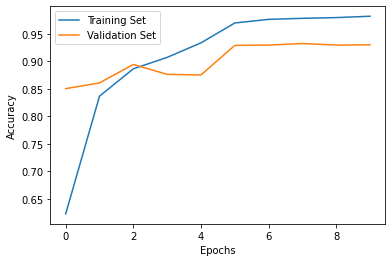

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Évaluation et commentaires

On commence par calculer l'accuracy globale sur le jeu de test :

In [ ]:
model.evaluate(testing_set)

80/80 [==============================] - 7s 88ms/step - loss: 0.2366 - accuracy: 0.9249


[0.2366374284029007, 0.9249213933944702]

Elle est comparable à celle mesurée pour le jeu de validation.

Elle est surtout **nettement meilleure que lorsqu'on cherche à modéliser 11 classes**.

Affichons le rapport de classification et la matrice de confusion :


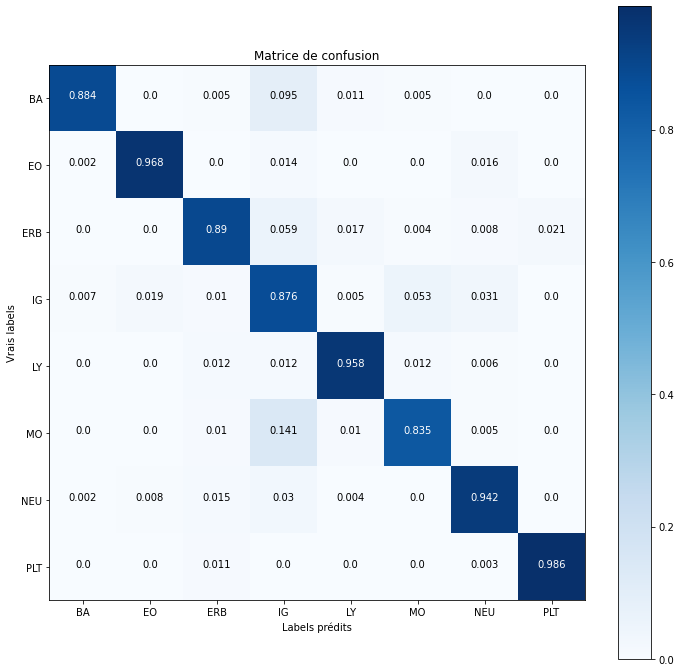

Classification Report 


,precision,recall,f1-score,support
BA,0.97093,0.883598,0.925208,189
EO,0.972093,0.967593,0.969838,432
ERB,0.909483,0.890295,0.899787,237
IG,0.811947,0.875895,0.84271,419
LY,0.930636,0.958333,0.944282,168
MO,0.868687,0.834951,0.851485,206
NEU,0.95229,0.941509,0.946869,530
PLT,0.986226,0.986226,0.986226,363


In [ ]:
### 1 -- Rapport de classification :
def print_classification_report(testing_set, labels):

  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report ")
  return display(df_report)


## Bilan sur les données de test :
print_classification_report(testing_set, label_map)

Rappelons d'abord que **IG = MY, MMY & PMY** et que **NEU = SNE + BNE**.

Le fait de fusionner ces classes a conduit à une très nette amélioration des F1-scores correspondants (**on masque partiellement les difficultés du modèle**).

Cependant, **il peut être pertinent de distinguer les sous-classes les plus immatures**, comme les PMY, car leur présence en grand excès peut traduire l'existence de maladies graves, comme certains types de leucémies.


**Le modèle est très irrégulier : un autre run avec exactement les mêmes jeux de données produit des métriques différentes de plusieurs pour-cent**. Le modèle semble très sensible au découpage en batches du jeu d'entraînement, seule différence réelle entre les deux runs.

**On ne peut pas s'arrêter là malgré le joli chiffre de 92% qu'on obtient parfois sur un run.** Il est cependant posssible de procéder en deux temps : trier 8 classes, puis trier les images de la lignée des neutrophiles (i.e. les classées NEU et IG en 5 classes (SNE, BNE, MY, PMY et MMY)). Cette approche a été utilisée pour le modèle VGG16 + SVM.

# Effet de l'augmentation de données

Nous revenons à 11 classes et allons implémenter de l'augmentation de données pour le jeu d'entraînement.

In [ ]:
df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

In [ ]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 11)

In [ ]:
batch_size = 32
img_height  = 256
img_width = 256

train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True,
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()


# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices

## Modèle & Entraînement

In [ ]:
model = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, 
                                                 input_shape = (img_height, img_width, 3)),
     layers.Conv2D(filters = 30,
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
     layers.Dense(units = n_classes, activation  = 'softmax')
     ])

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
## Training

TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set)

Epoch 1/30
397/397 [==============================] - 227s 527ms/step - loss: 1.5292 - accuracy: 0.4829 - val_loss: 1.1561 - val_accuracy: 0.5977
Epoch 2/30
397/397 [==============================] - 207s 521ms/step - loss: 0.9813 - accuracy: 0.6464 - val_loss: 0.8792 - val_accuracy: 0.6624
Epoch 3/30
397/397 [==============================] - 205s 516ms/step - loss: 0.7721 - accuracy: 0.7122 - val_loss: 0.7642 - val_accuracy: 0.7191
Epoch 4/30
397/397 [==============================] - 204s 515ms/step - loss: 0.6739 - accuracy: 0.7436 - val_loss: 0.6848 - val_accuracy: 0.7306
Epoch 5/30
397/397 [==============================] - 204s 515ms/step - loss: 0.6281 - accuracy: 0.7573 - val_loss: 0.5744 - val_accuracy: 0.7775
Epoch 6/30
397/397 [==============================] - 206s 520ms/step - loss: 0.5882 - accuracy: 0.7687 - val_loss: 0.5119 - val_accuracy: 0.7948
Epoch 7/30
397/397 [==============================] - 204s 513ms/step - loss: 0.5380 - accuracy: 0.7861 - val_loss: 0.5308 -

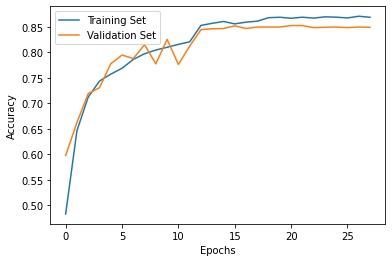

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Évaluation et analyse

Pour gagner du temps, on importe les poids du modèle déjà entraîné :

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/LeNetModel/lenet_save")
model.evaluate(testing_set)

80/80 [==============================] - 8s 102ms/step - loss: 0.3607 - accuracy: 0.8616


[0.36070516705513, 0.8616352081298828]

On constate une quasi disparition de l'overfitting, grâce à l'augmentation de données.

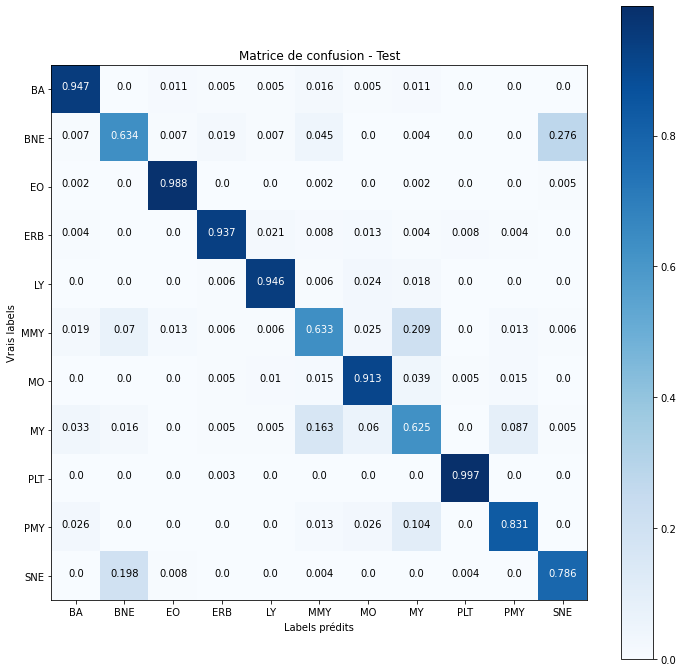

Classification Report - Test


,precision,recall,f1-score,support
BA,0.92268,0.94709,0.934726,189
BNE,0.720339,0.634328,0.674603,268
EO,0.981609,0.988426,0.985006,432
ERB,0.95279,0.936709,0.944681,237
LY,0.929825,0.946429,0.938053,168
MMY,0.649351,0.632911,0.641026,158
MO,0.882629,0.912621,0.897375,206
MY,0.668605,0.625,0.646067,184
PLT,0.989071,0.997245,0.993141,363
PMY,0.744186,0.831169,0.785276,77


In [ ]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

Autre effet positif, **l'augmentation de données a amélioré le F1-score pour la quasi-totalité des classes**, en particulier celles qui étaient le moins bien décrites.

In [ ]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

Pour mesurer le surapprentissage classe par classe, on va calculer le rapport de classification pour le jeu d'entraînement.

Found 12677 validated image filenames belonging to 11 classes.


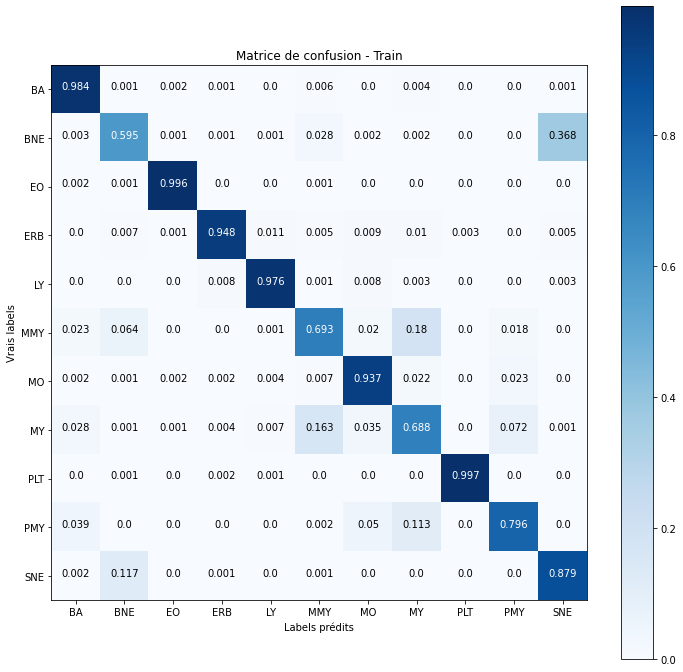

Classification Report - Train


,precision,recall,f1-score,support
BA,0.925078,0.984496,0.953863,903
BNE,0.775269,0.594884,0.673203,1212
EO,0.997021,0.996173,0.996597,2352
ERB,0.982159,0.947504,0.96452,1162
LY,0.972603,0.975687,0.974142,946
MMY,0.72404,0.69346,0.70842,734
MO,0.919192,0.937266,0.928141,1068
MY,0.715356,0.687875,0.701346,833
PLT,0.997702,0.996558,0.99713,1743
PMY,0.789247,0.796095,0.792657,461


In [ ]:
### 1-bis -- Rapport de classification (training_set bis) :

train_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set2 = train_generator.flow_from_dataframe(df_train, 
                                                    directory = None, # utilise x_col
                                                    x_col = 'img_path',
                                                    y_col = 'label',
                                                    target_size = (img_height, img_width), 
                                                    color_mode = 'rgb',
                                                    classes = None,   # utilise y_col
                                                    class_mode = 'categorical', 
                                                    batch_size = batch_size,
                                                    shuffle = False)  # sinon c'est le chaos

## Bilan sur les données de test :
y_train_pred, df_report_train = print_classification_report(training_set2, label_map, title = "Train")

Intéressons-nous au **Grad-CAM des images bien classées** :

In [ ]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

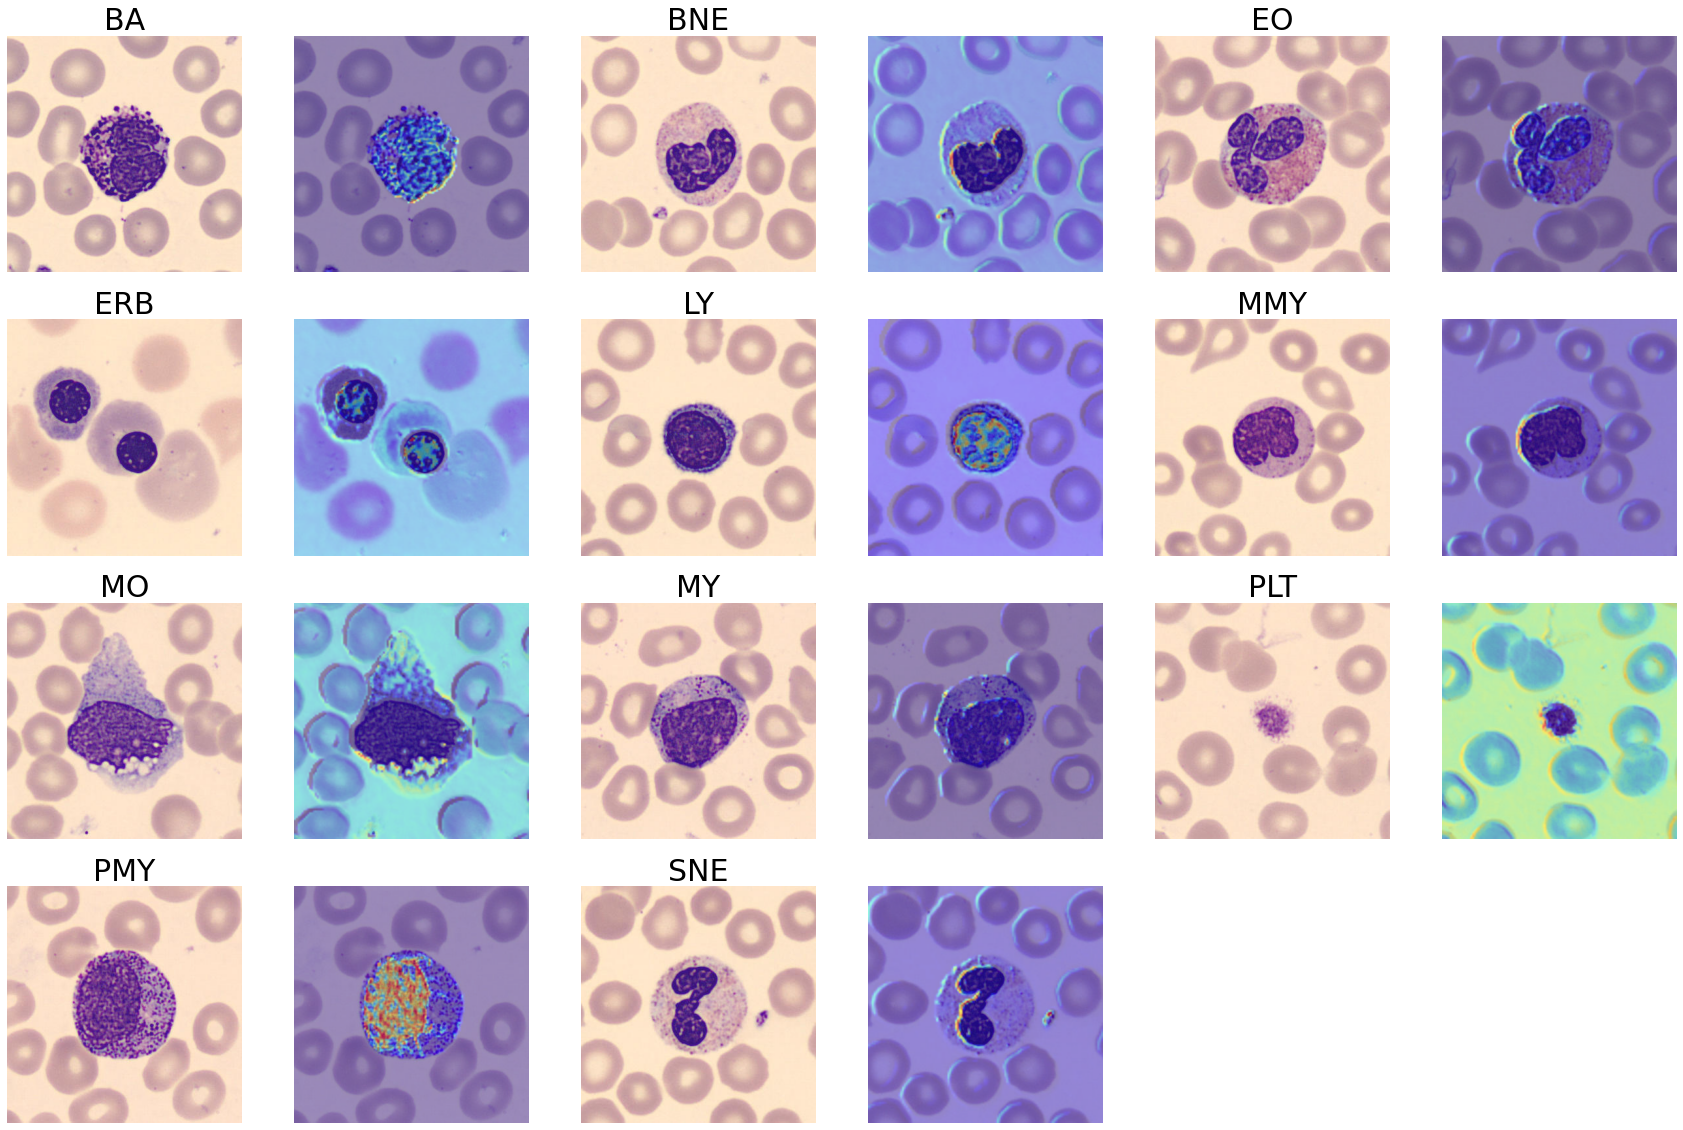

In [ ]:
fig = plt.figure(figsize = (30, 20))
i = 0

for cell_class in range(n_classes):
  df_temp = df_results[(df_results["label"] == cell_class) & (df_results["well_classified"] == True)]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_temp.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(4,6,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(4,6,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

L'**augmentation de données a conduit le modèle à prendre en compte d'autres caractéristiques des images** :

- la structure interne du noyau (MO, MY, PMY, MMY),
- les granulations éosinophiles (roses) des EO.

L'**augmentation de données semble donc être une piste intéressante** :

- meilleures performances (métriques, moins d'overfitting),
- Grad-CAM plus pertinente.